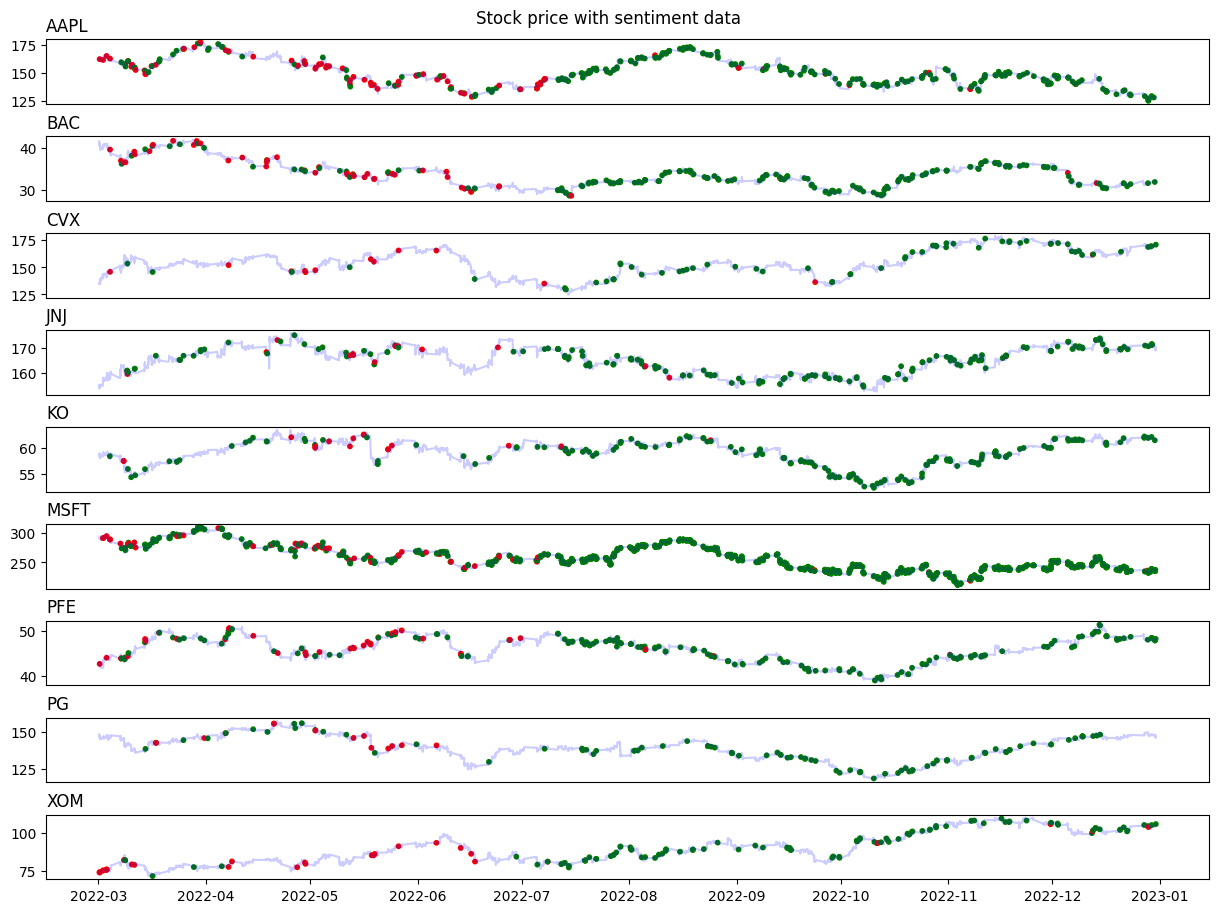

In [23]:
# merge sentiments

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

symbols = [
    "AAPL", "BAC", "CVX", "JNJ", "KO", "MSFT", "PFE", "PG", "XOM"
]

plt.figure(figsize=(15, 10))
plt.suptitle("Stock price with sentiment data")
plt.subplots_adjust(top=0.95, hspace=0.5)

for i, symbol in enumerate(symbols):

    price_data = pd.read_csv('./dataset/' + symbol + '.csv')
    sentiment_data = pd.read_csv(
        './dataset/sentiments/' + symbol + '.csv')

    sentiment_data["Timestamp"] = pd.to_datetime(sentiment_data["time_published"])
    sentiment_data["sentiment"] = sentiment_data["sentiment"].replace(
        {'positive': 1, 'negative': -1, 'neutral': 0})

    # change type to int
    sentiment_data["sentiment"] = sentiment_data["sentiment"].astype(int)
    sentiment_data.set_index("Timestamp", inplace=False, drop=True)
    sentiment_data = sentiment_data[["Timestamp", "sentiment"]]
    sentiment_data.sort_index(inplace=True)
    sentiment_data.head()

    price_data["Timestamp"] = pd.to_datetime(price_data["Timestamp"])

    # use only data from 2022-03 to 2022-12
    price_data = price_data[(price_data["Timestamp"] >= "2022-03-01") & (
        price_data["Timestamp"] <= "2022-12-31")]

    # add sentiment data to price data by merging on timestamp and if no matching data, put 0
    data = pd.merge(price_data, sentiment_data, on="Timestamp", how="left")
    data["sentiment"] = data["sentiment"].fillna(0)
    data["sentiment"] = data["sentiment"].astype(int)

    sentiment_scatter_data = data[data["sentiment"] != 0]
    sentiment_scatter_data = sentiment_scatter_data[["Timestamp", "Close", "sentiment"]]

    colors = sentiment_scatter_data["sentiment"].replace({1: 'green', -1: 'red'})

    fig = plt.subplot(len(symbols), 1, i + 1)
    plt.scatter(sentiment_scatter_data["Timestamp"], sentiment_scatter_data["Close"], color=colors, s=10)

    plt.plot(data["Timestamp"], data["Close"], color='blue', alpha=0.2)
    if i != len(symbols) - 1:
        fig.axes.get_xaxis().set_ticks([])
    # Create legend with corresponding color dots
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Positive', markerfacecolor='green', markersize=5),
                    plt.Line2D([0], [0], marker='o', color='w', label='Negative', markerfacecolor='red', markersize=5)]
    plt.title(symbol, loc='left')  # Add this line to set the title to the left
    # plt.legend(handles=legend_elements)

plt.show()


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

symbols = [
    "AAPL", "BAC", "CVX", "JNJ", "KO", "MSFT", "PFE", "PG", "XOM"
]
for symbol in symbols:
    price_data = pd.read_csv('./dataset/' + symbol + '.csv')
    price_data = price_data[(price_data["Timestamp"] >= "2022-03-01") & (
        price_data["Timestamp"] <= "2022-12-31")]
    
    # for every 24 timeframe add artificial sentiment data which correctly predicts the price
    # if the price going up after 24 timeframe, put 1, if going down put -1, if similar put 0
    price_data["sentiment"] = 0
    for i in range(1, len(price_data) - 96, 24):
        if price_data.iloc[i + 96]["Close"] > price_data.iloc[i]["Close"]:
            price_data.at[i, "sentiment"] = 1
        else:
            price_data.at[i, "sentiment"] = -1
    price_data = price_data.iloc[:-96 - 24]
    price_data.to_csv('./dataset/' + symbol + '_with_correct_sentiment.csv', index=False)



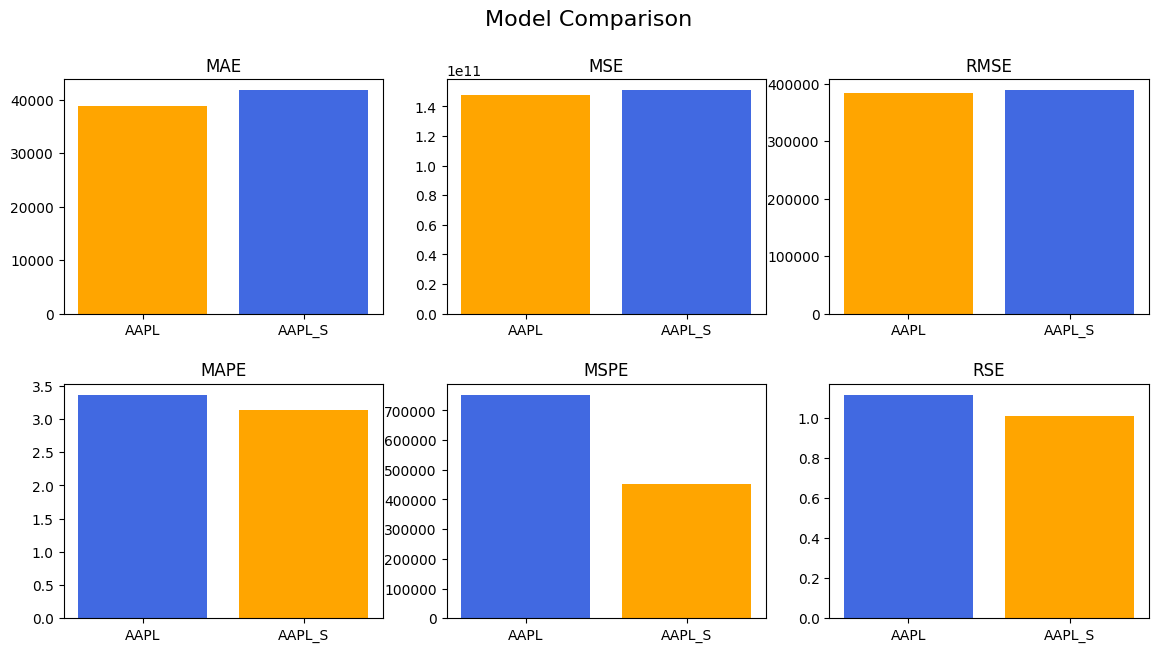

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from utils import metrics

model_ids = {
    # "AAPL": "PatchTST_AAPL_336_96",
    # "MSFT": "PatchTST_MSFT_336_96",
    # "JPM": "PatchTST_JPM_336_96",
    # "BAC": "PatchTST_BAC_336_96",
    # "KO": "PatchTST_KO_336_96",
    # "PG": "PatchTST_PG_336_96",
    # "JNJ": "PatchTST_JNJ_336_96",
    # "PFE": "PatchTST_PFE_336_96",
    # "XOM": "PatchTST_XOM_336_96",
    # "CVX": "PatchTST_CVX_336_96",
    # "PatchTST": "PatchTST_AAPL_336_96",
    # "Autoformer": "Autoformer_AAPL_336_96",
    # "Transformer": "Transformer_AAPL_336_96",
    # "DLinear": "DLinear_AAPL_336_96",
    # "PatchTST": "PatchTST_AAPL_pct_336_96",
    # "Autoformer": "Autoformer_AAPL_pct_336_96",
    # "Transformer": "Transformer_AAPL_pct_336_96",
    # "DLinear": "DLinear_AAPL_pct_336_96",
    "AAPL": "PatchTST_AAPL_with_sentiment_336_96",
    "AAPL_S": "PatchTST_AAPL_without_sentiment_336_96",
    "AAPL_CS": "PatchTST_AAPL_with_correct_sentiment_336_96",
}


def getPath(model_id):
    return "./results/" + model_id + "/data/"


df = pd.DataFrame(columns=['model_name', 'model_id', 'mae', 'mse',
                  'rmse', 'mape', 'mspe', 'rse'])

for i, (model_name, model_id) in enumerate(model_ids.items()):
    data_path = getPath(model_id)
    # analysis_data = np.load(data_path + "metrics.npy")
    preds = np.load(data_path + "pred.npy")
    trues = np.load(data_path + "true.npy")

    analysis_data = metrics.metric(trues, preds)
    
    model_data = pd.DataFrame({
        'model_name': model_name,
        'model_id': model_id,
        'mae': analysis_data[0],
        'mse': analysis_data[1],
        'rmse': analysis_data[2],
        'mape': analysis_data[3],
        'mspe': analysis_data[4],
        'rse': analysis_data[5]
    }, index=[i])

    df = pd.concat([df, model_data], ignore_index=True)

df.to_csv('model_comparison_pct.csv', index=False)

fig = plt.figure(figsize=(14, 7))
fig.subplots_adjust(hspace=0.3, wspace=0.2)
width = 0.8
r = np.arange(2)
fig.suptitle('Model Comparison', fontsize=16)

for i, column in enumerate(df.columns):
    if column == 'model_name' or column == 'model_id':
        continue
    index = i - 2

    colors = []
    for value in df[column]:
        if value == df[column].min():
            colors.append('orange')
        else:
            colors.append('royalblue')

    axes = plt.subplot(2, 3, index + 1)
    axes.bar(df['model_name'], df[column], width=width, color=colors)
    axes.set_title(column.upper())